# Test reconstruction

Script to test for reconstruction (for now, of synthetic data) for a different number of timepoints, plotting, etc

In [28]:
#Import
# working dir
%cd /homedtic/gmarti/CODE/RNN-VAE/

# Imports
import sys
sys.path.insert(0, '/homedtic/gmarti/CODE/RNN-VAE/')
from rnnvae.utils import open_MRI_data_var
from rnnvae import rnnvae
from rnnvae.plot import plot_losses, plot_trajectory, plot_total_loss, plot_z_2d, plot_z_time_2d
import os
import math
from rnnvae.data_gen import SinDataGenerator
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import torch

%matplotlib inline

/homedtic/gmarti/CODE/RNN-VAE


In [29]:
import torch


In [59]:
# DEVICE
## Decidint on device on device.
DEVICE_ID = 0
DEVICE = torch.device('cuda:' + str(DEVICE_ID) if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_ID)

out_dir = "experiments/meta_synth_padding_linspace/_h_5_z_3_hid_5_ntp_15_n_800/"

#load parameters
p = eval(open(out_dir + "params.txt").read())
print(p['curves'])


model = rnnvae.ModelRNNVAE(p["x_size"], p["h_size"], p["hidden"], p["n_layers"], 
                        p["hidden"], p["n_layers"], p["hidden"],
                        p["n_layers"], p["z_dim"], p["hidden"], p["n_layers"],
                        p["clip"], p["n_epochs"], p["batch_size"], DEVICE)
model.load(out_dir+'model.pt')
model = model.to(DEVICE)

[('sigmoid', {'L': 1, 'k': 1, 'x0': 5}), ('sin', {'A': 1, 'f': 0.2}), ('cos', {'A': 1, 'f': 0.2}), ('sigmoid', {'L': 1, 'k': -15, 'x0': 5}), ('sigmoid', {'L': 1, 'k': 5, 'x0': 5})]


For a specific value, generate it for a given number of timepoints and plot it

In [60]:
#Generate data, with different parameters
n_known = 3
n_generated_samples = 50
n_rec_tp = 15

# Create first samples with only one timepoint
gen_model = SinDataGenerator(p["curves"], n_rec_tp, 0.0)
samples = gen_model.generate_n_samples(n_generated_samples)
X_samples = np.asarray([y[:n_known] for (_,y) in samples])
X_samples_tensor = torch.FloatTensor(X_samples).permute((1,0,2))

#Reconstruct it
X_sample = model.sequence_predict(X_samples_tensor.to(DEVICE), n_rec_tp)

recon_x = np.array(X_sample['xnext']).swapaxes(0,1)
recon_zx = np.array(X_sample['z']).swapaxes(0,1)

print(X_samples.shape)
print(recon_x.shape)

(50, 3, 5)
(50, 15, 5)


And now, plot it!

<Figure size 720x720 with 0 Axes>

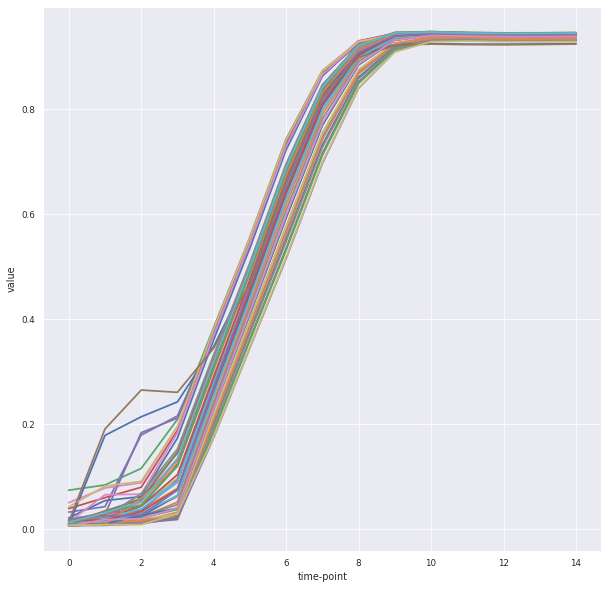

In [61]:
plt.figure(figsize=(10, 10))
feat = 0
sns.set_theme()
sns.set_context("paper")

# create figure, plot it
plt.figure(figsize=(10,10))
for (sample, recon) in zip(X_samples, recon_x):
    # Plot the two lines (for a given feature)
    #plt.plot(range(len(sample[:,feat])), sample[:,feat], 'xb', markersize=5, label='X (original)')
    plt.plot(range(len(recon[:,feat])), recon[:,feat], linewidth=1.75, label='X (predicted)')

plt.xlabel("time-point")
plt.ylabel("value")
plt.show()

(500, 15, 5)
(500, 15, 5)
(500, 15, 5)
(500, 15, 5)


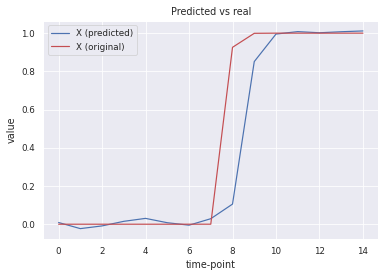

In [72]:
# Test reconstruction of samples
#Generate data, with different parameters
n_generated_samples = 500
n_rec_tp = 15

# Create first samples with only one timepoint
gen_model = SinDataGenerator(p["curves"], n_rec_tp, 0.0)
samples = gen_model.generate_n_samples(n_generated_samples)
X_samples = np.asarray([y for (_,y) in samples])
X_samples_tensor = torch.FloatTensor(X_samples).permute((1,0,2))

# Predict the reconstructions from X_val and X_train
X_fwd = model.predict(X_samples_tensor.to(DEVICE))

#Reformulate things
X_fwd['xnext'] = np.array(X_fwd['xnext']).swapaxes(0,1)
X_fwd['z'] = np.array(X_fwd['z']).swapaxes(0,1)

X_hat = X_fwd["xnext"]

feat = 4
subj = 0

print(X_hat.shape)
print(X_samples.shape)
X_hat_line = X_hat[subj,:,feat]   #Select only the subject we want
X_samples_line = X_samples[subj,:,feat]   #Select only the subject we want
print(X_hat.shape)
print(X_samples.shape)
# Plot the two lines
plt.plot(range(len(X_hat_line)), X_hat_line, '-b', label='X (predicted)')
plt.plot(range(len(X_samples_line)), X_samples_line, '-r', label='X (original)')

plt.xlabel("time-point")
plt.ylabel("value")

plt.legend(loc='upper left')
plt.title("Predicted vs real")
plt.show()

(500, 30, 5)
(500, 15, 5)
(500, 30, 5)
(500, 15, 5)


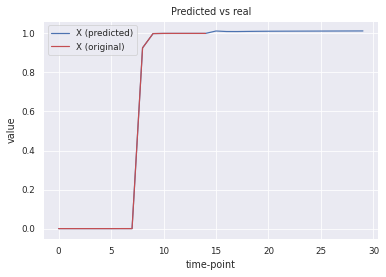

In [78]:
# Predict the reconstructions from X_val and X_train
extra_nt = 30
X_fwd = model.sequence_predict(X_samples_tensor.to(DEVICE), extra_nt)

#Reformulate things
X_fwd['xnext'] = np.array(X_fwd['xnext']).swapaxes(0,1)
X_fwd['z'] = np.array(X_fwd['z']).swapaxes(0,1)

X_hat = X_fwd["xnext"]

feat = 4
subj = 0

print(X_hat.shape)
print(X_samples.shape)
X_hat_line = X_hat[subj,:,feat]   #Select only the subject we want
X_samples_line = X_samples[subj,:,feat]   #Select only the subject we want
print(X_hat.shape)
print(X_samples.shape)
# Plot the two lines
plt.plot(range(len(X_hat_line)), X_hat_line, '-b', label='X (predicted)')
plt.plot(range(len(X_samples_line)), X_samples_line, '-r', label='X (original)')

plt.xlabel("time-point")
plt.ylabel("value")

plt.legend(loc='upper left')
plt.title("Predicted vs real")
plt.show()

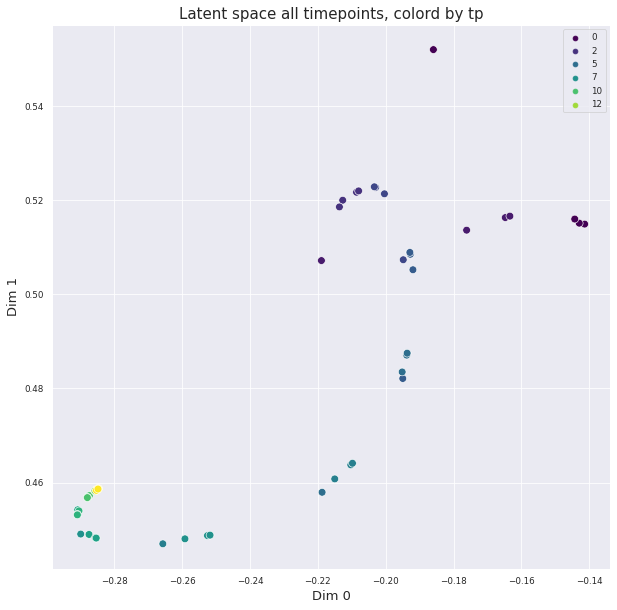

In [8]:
# Plot the latent space
dim0 = 0
dim1 = 1

plt.figure(figsize=(10, 10))
# create color cmap
pallete = sns.color_palette("viridis", n_rec_tp)

z_d0_full = []
z_d1_full = []
tp_full = []
for tp in range(n_rec_tp):

    z_d0 = [x[tp, dim0] for x in recon_zx if x.shape[0] > tp]
    z_d1 = [x[tp, dim1] for x in recon_zx if x.shape[0] > tp]

    #populate 
    z_d0_full = z_d0_full + z_d0
    z_d1_full = z_d1_full + z_d1
    tp_full = tp_full + [tp]*(len(z_d0))


sns.scatterplot(x=z_d0_full,y=z_d1_full,hue=tp_full, palette="viridis", s=60)
##Add title, x and y axis
plt.xlabel(f"Dim {dim0}", size=13)
plt.ylabel(f"Dim {dim1}", size=13)
plt.title(f"Latent space all timepoints, colord by tp", size=15)
plt.show()

Now, try to do a large number of samples from the same initial subsample, and see how they vary.

In [8]:
n_iter = 1000

x_full_samples = np.zeros((n_iter, n_rec_tp, p['x_size']))
z_full_samples = np.zeros((n_iter, n_rec_tp, p['z_dim']))

for n in range(n_iter):
    
    #generate for initial position
    samples = gen_model.generate_n_samples(n_generated_samples)
    X_samples = np.asarray([y for (_,y) in samples])
    X_samples_tensor = torch.FloatTensor(X_samples).permute((1,0,2))
    X_sample = model.sequence_predict(X_samples_tensor.to(DEVICE), n_rec_tp)
    
    
    #Sample from prior, no input
    #X_sample = model.sample_latent(1, n_rec_tp)
    
    recon_x = np.array(X_sample['xnext']).swapaxes(0,1)
    recon_zx = np.array(X_sample['z']).swapaxes(0,1)
    x_full_samples[n, :, :] = recon_x
    z_full_samples[n, :, :] = recon_zx

ValueError: could not broadcast input array from shape (500,15,5) into shape (15,5)

In [ ]:
#Plot it against time points (horizontally)
feat = 0
sns.set_theme()
sns.set_context("paper")

# create figure, plot it
plt.figure(figsize=(10,10))
for line in x_full_samples:
    plt.plot(list(range(len(line[:, feat]))), line[:, feat], linewidth=0.5)

plt.xlabel("time-point")
plt.ylabel("value")
plt.show()

In [ ]:
# Plot latent space
dim0 = 1
dim1 = 0

plt.figure(figsize=(10, 10))
# create color cmap
pallete = sns.color_palette("viridis", n_rec_tp)

z_d0_full = []
z_d1_full = []
tp_full = []
for tp in range(n_rec_tp):

    z_d0 = [x[tp, dim0] for x in z_full_samples if x.shape[0] > tp]
    z_d1 = [x[tp, dim1] for x in z_full_samples if x.shape[0] > tp]

    #populate 
    z_d0_full = z_d0_full + z_d0
    z_d1_full = z_d1_full + z_d1
    tp_full = tp_full + [tp]*(len(z_d0))


sns.scatterplot(x=z_d0_full,y=z_d1_full,hue=tp_full, palette="viridis", s=60)
##Add title, x and y axis
plt.xlabel(f"Dim {dim0}", size=13)
plt.ylabel(f"Dim {dim1}", size=13)
plt.title(f"Latent space all timepoints, colord by tp", size=15)
plt.show()